In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
from lux.lux import LUX
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Iris example

In [170]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'
rs=42
fraction=0.1

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = MLPClassifier(random_state=rs)# svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Withoiut uncertainty of predictor 

In [171]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
def noproba_predictor(x):
    preds = clf.predict_proba(x)
    hot = np.argmax(preds,axis=1)
    result = np.zeros(preds.shape)
    for i in range(0,len(result)):
        result[i,hot[i]] = 1
    return result

lux = LUX(predict_proba = lambda x: noproba_predictor(x), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2],n_jobs=1)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF petal_length <2.449999988079071 THEN class = 0 # 1.0\n']

In [172]:
lux.counterfactual(np.array(iris_instance), train[features], counterfactual_representative='nearest', topn=1)

[{'rule': {'petal_length': ['<4.299999952316284', '>=2.449999988079071']},
  'prediction': '1',
  'confidence': 1.0,
  'covered':     sepal_length  sepal_width  petal_length  petal_width
  81           5.5          2.4           3.7          1.0
  96           5.7          2.9           4.2          1.3
  67           5.8          2.7           4.1          1.0
  60           5.0          2.0           3.5          1.0
  94           5.6          2.7           4.2          1.3
  95           5.7          3.0           4.2          1.2
  62           6.0          2.2           4.0          1.0
  53           5.5          2.3           4.0          1.3
  93           5.0          2.3           3.3          1.0
  80           5.5          2.4           3.8          1.1
  98           5.1          2.5           3.0          1.1
  89           5.5          2.5           4.0          1.3
  61           5.9          3.0           4.2          1.5
  79           5.7          2.6           3.5 

In [173]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.7894736842105263


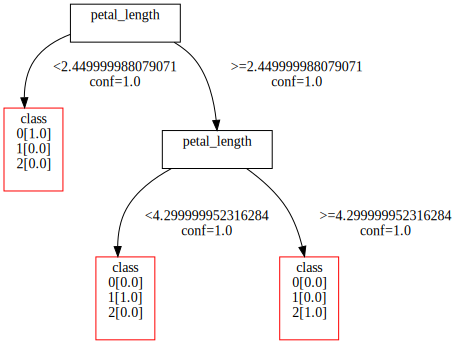

In [174]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance')

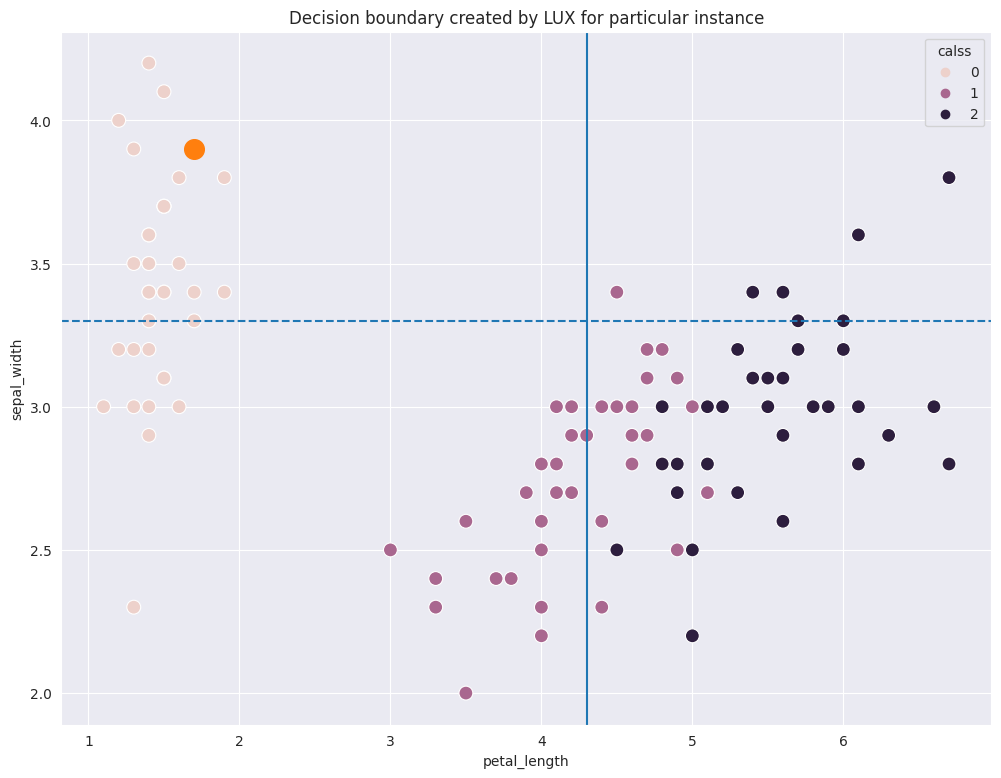

In [175]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='sepal_width', data=train[['petal_length','sepal_width', target]],hue=target,s=100)
graph.axhline(3.3,0, linestyle='--')
graph.axvline(4.3)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='sepal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance')

### Without SHAP support

In [176]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF petal_length <2.449999988079071 THEN class = 0 # 1.0\n']

In [177]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.7894736842105263


In [178]:
#have a look at the entire rule-based model that can be executed with https:://heartdroid.re
print(lux.to_HMR())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TYPES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%

xtype [
 name: petal_length, 
base:numeric,
domain : [-100000 to 100000]].
xtype [
 name: class, 
base:symbolic,
 domain : [2,0,1]].

%%%%%%%%%%%%%%%%%%%%%%%%% ATTRIBUTES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%
xattr [ name: petal_length,
 type:petal_length,
 class:simple,
 comm:out ].
xattr [ name: class,
 type:class,
 class:simple,
 comm:out ].

%%%%%%%%%%%%%%%%%%%%%%%% TABLE SCHEMAS DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%
 xschm tree : [petal_length]==> [class].
xrule tree/0:
[petal_length  lt 2.449999988079071] ==> [class set 0]. # 1.0
xrule tree/1:
[petal_length  gte 2.449999988079071, petal_length  lt 4.299999952316284] ==> [class set 1]. # 1.0
xrule tree/2:
[petal_length  gte 2.449999988079071, petal_length  gte 4.299999952316284] ==> [class set 2]. # 1.0


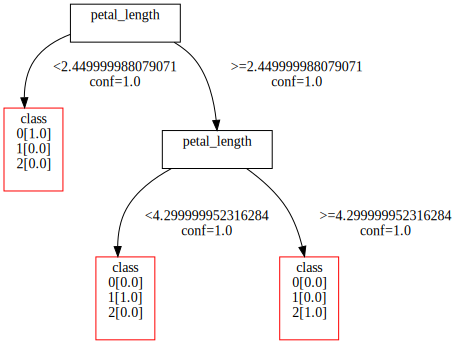

In [179]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## In fact, the explanation above is overcomplicated
The explanation can be made only using petal_lenght, but due to the greadiness of decision tree classifier, algorithm could not select correct split criterion for the fist place

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance')

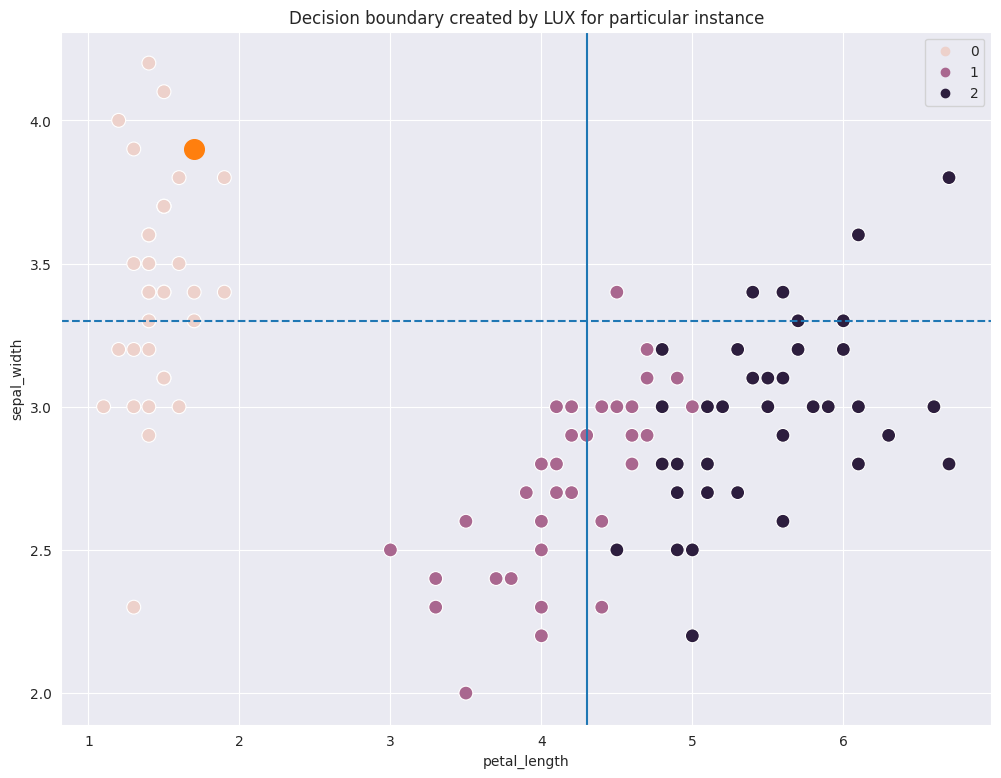

In [180]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='sepal_width', data=train[['petal_length','sepal_width', target]],hue=clf.predict(train[features]),s=100)
graph.axhline(3.3,0, linestyle='--')
graph.axvline(4.3)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='sepal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance')

## Iris example with SHAP values
The explanation is more compact, and more consistend with the model, hence, the LUX tree with SHAP support obtains more accuray on the whole dataset, wing smaller than LUX tree without SHAP support

In [181]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = svm.SVC(probability=True,random_state=rs)
clf.fit(train[features].values,train[target])
clf.score(test[features].values,test[target])

1.0

In [182]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(clf.predict_proba, train[features])
shap_values = explainer.shap_values(train[features])

Using 112 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/112 [00:00<?, ?it/s]

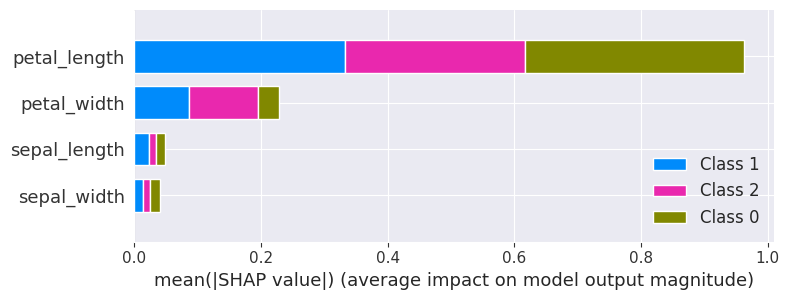

In [183]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [184]:
#train lux on neighbourhood equal 30% instances
import warnings
warnings.filterwarnings('ignore')
lux = LUX(predict_proba = clf.predict_proba,classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1,2],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF petal_length <2.449999988079071 THEN class = 0 # 1.0\n']

In [185]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8157894736842105


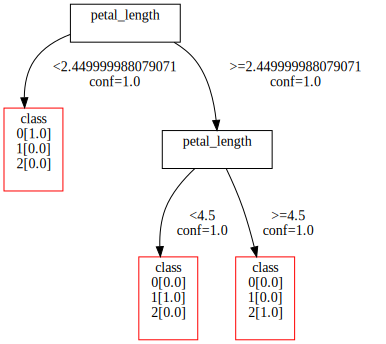

In [186]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance with SHAP support')

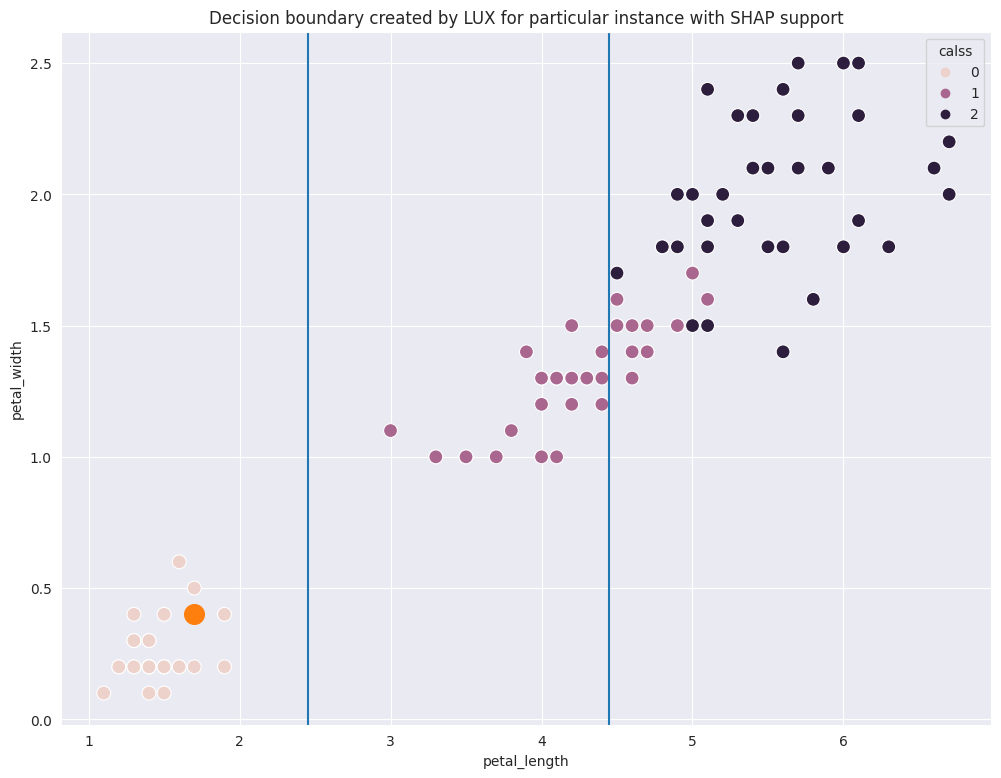

In [188]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='petal_width', data=train[['petal_length','petal_width',target]],hue=target,s=100)
graph.axvline(2.45)
graph.axvline(4.45)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='petal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')

# Wine example

In [189]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
wine = datasets.load_wine()

In [190]:
features = wine['feature_names']
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_wine = pd.DataFrame(wine.data,columns=features)
df_wine[target] = wine.target

#train classifier
train, test = train_test_split(df_wine, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Without predictor uncertainty

In [191]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF od280/od315_of_diluted_wines <2.2050000429153442 THEN class = 2 # 0.9285714285714286\n']

In [192]:
#calculate decision tree score over this dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8222222222222222


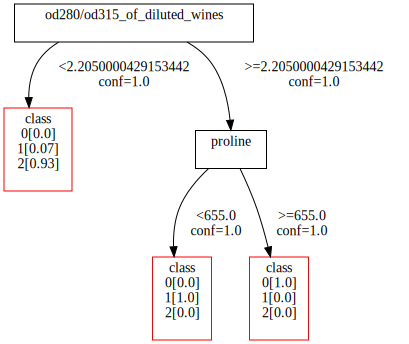

In [193]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## Without SHAP

In [194]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 20 instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF malic_acid >=1.6249999701976776 AND od280/od315_of_diluted_wines <2.2050000429153442 THEN class = 2 # 1.0\n']

In [195]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8666666666666667


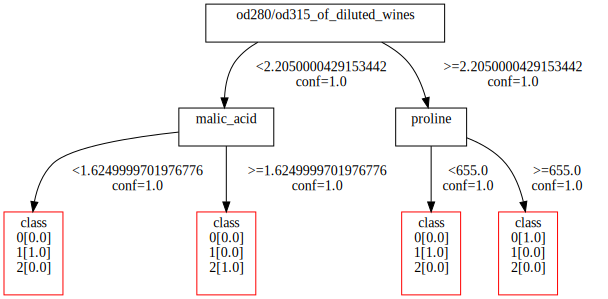

In [196]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance without SHAP support')

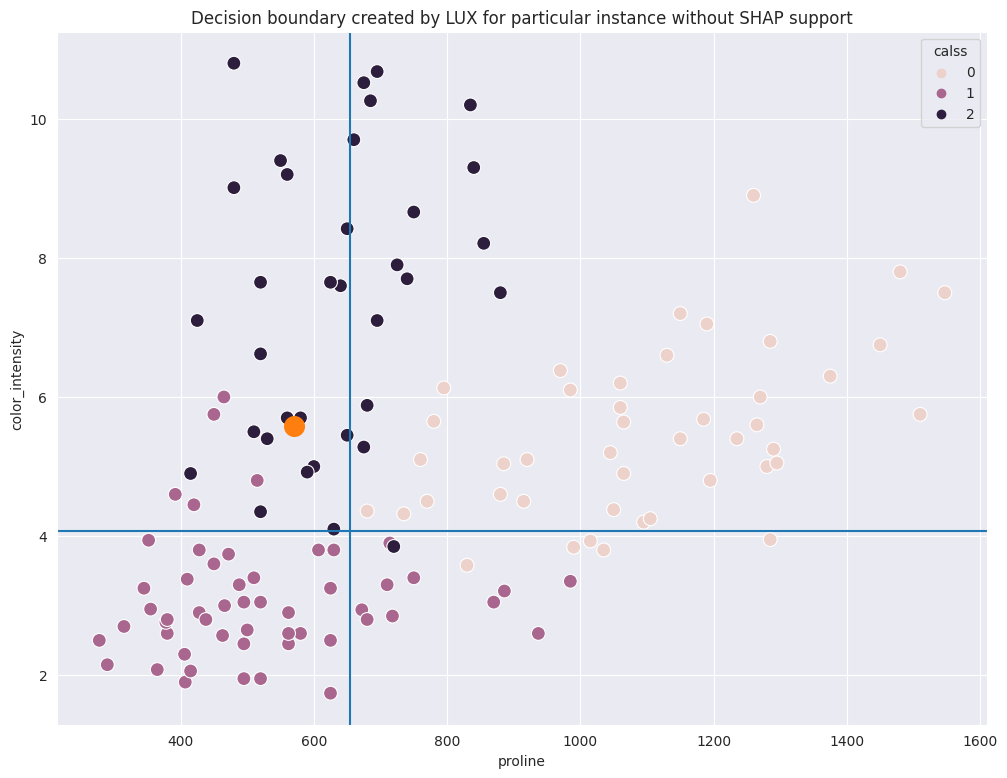

In [197]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='proline',y='color_intensity', data=train[['proline','color_intensity',target]],hue=target,s=100)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='proline',y='color_intensity', marker='o', s=200)
graph.axhline(4.07)
graph.axvline(655)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')

## With SHAP

In [198]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf, train[features])
shap_values = explainer.shap_values(train[features],check_additivity=False)

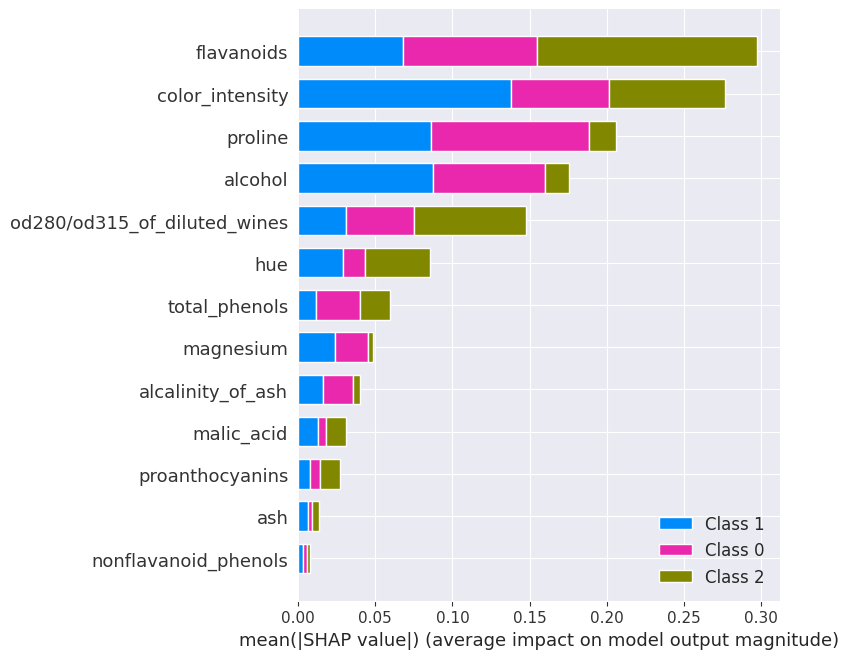

In [199]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [200]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1,2],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF color_intensity >=3.424999952316284 AND flavanoids <1.4900000095367432 THEN class = 2 # 1.0\n']

In [201]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9111111111111111


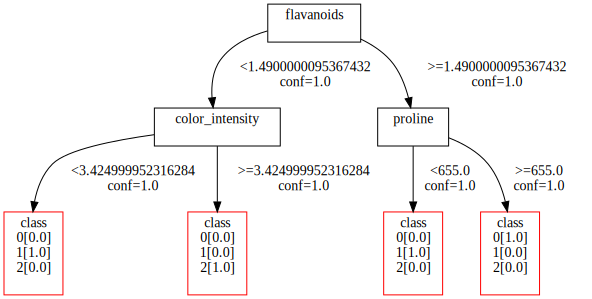

In [202]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance SHAP support')

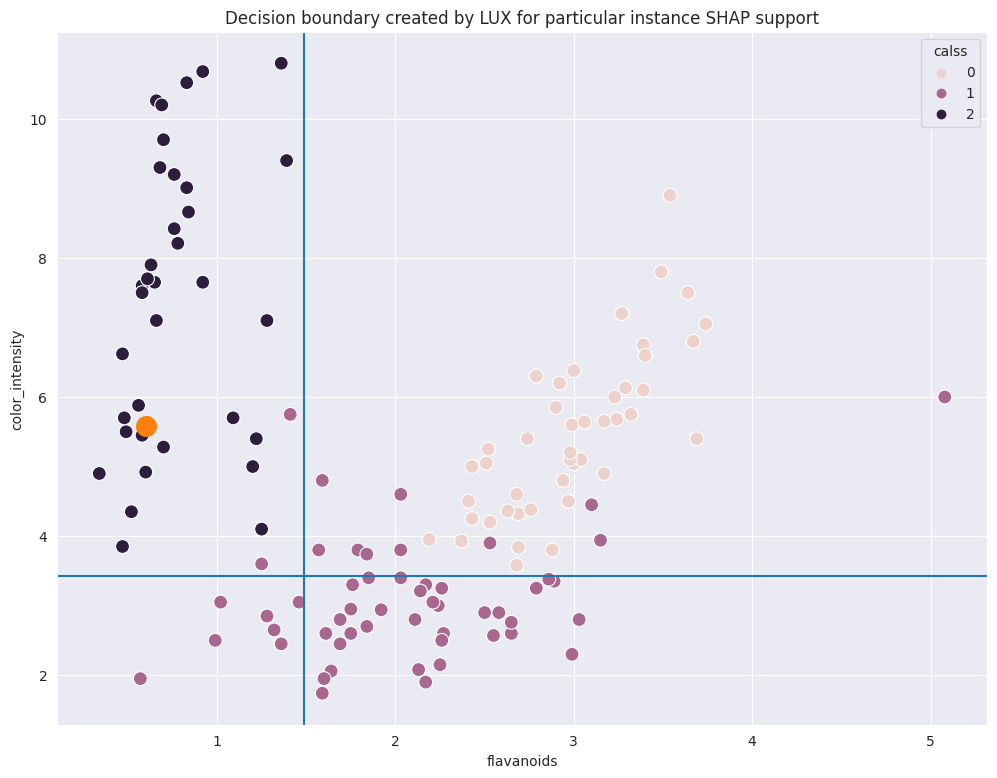

In [203]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='flavanoids',y='color_intensity', data=train[['flavanoids','color_intensity',target]],hue=target,s=100)
graph.axvline(1.49)
graph.axhline(3.425)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='flavanoids',y='color_intensity', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance SHAP support')

# Breast cancer

In [204]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
cancer = datasets.load_breast_cancer()

In [205]:
features = [f.replace(" ","_") for f in cancer['feature_names']]
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_cancer = pd.DataFrame(cancer.data,columns=features)
df_cancer[target] = cancer.target

#train classifier
train, test = train_test_split(df_cancer, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.965034965034965

## Without predictor uncertinaty

In [206]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF worst_radius <16.755000114440918 AND worst_concave_points <0.1423499956727028 THEN class = 1 # 0.9076923076923077\n']

In [207]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.916083916083916


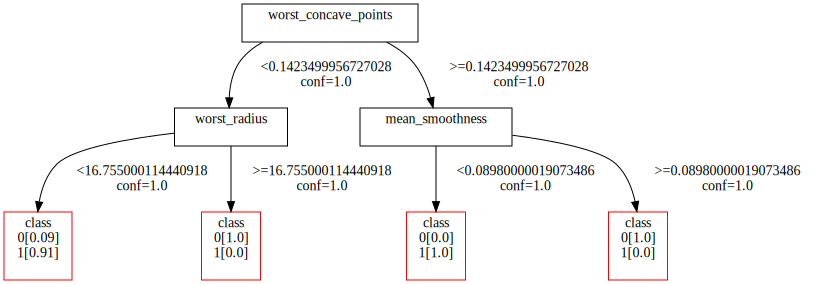

In [208]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## Without SHAP

In [209]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF worst_radius <16.755000114440918 AND worst_concave_points <0.14305000007152557 THEN class = 1 # 0.9830508474576272\n']

In [210]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9230769230769231


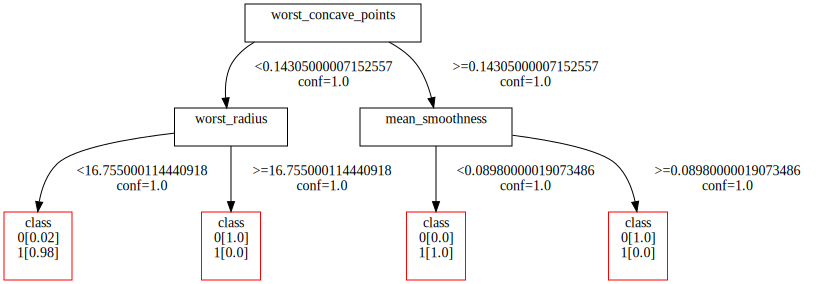

In [211]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance without SHAP support')

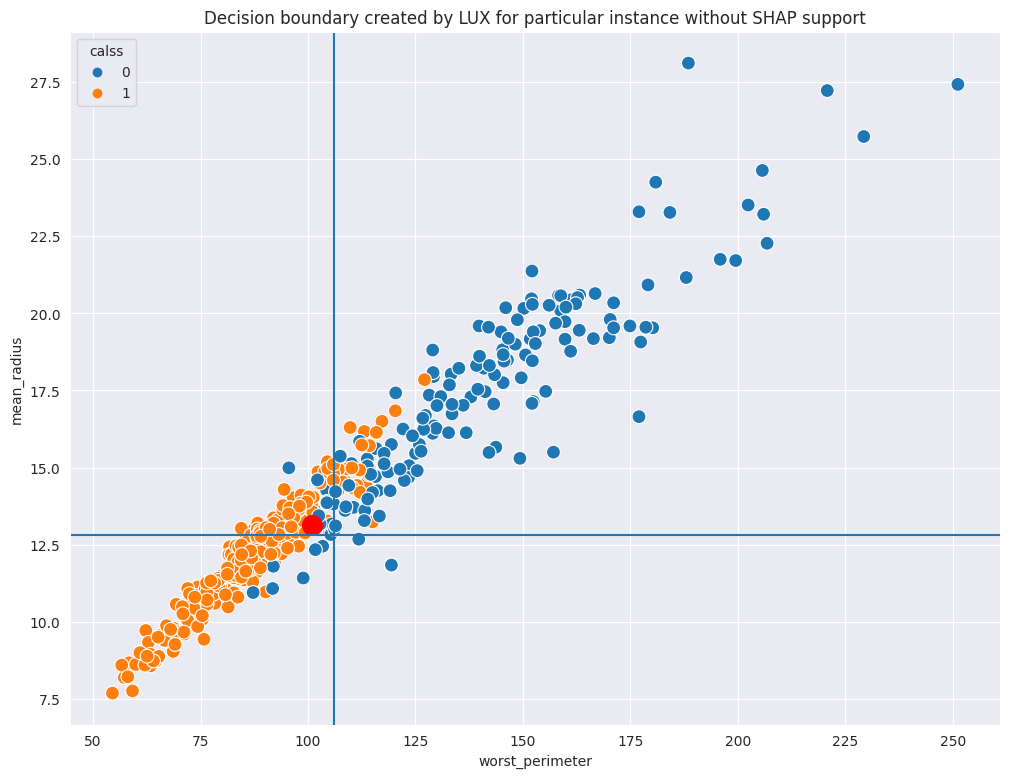

In [212]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_perimeter',y='mean_radius', data=train[['worst_perimeter','mean_radius',target]],hue=target,s=100)
graph.axvline(105.95)
graph.axhline(12.8)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='worst_perimeter',y='mean_radius', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')

## With SHAP

In [213]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(train[features],check_additivity=True)

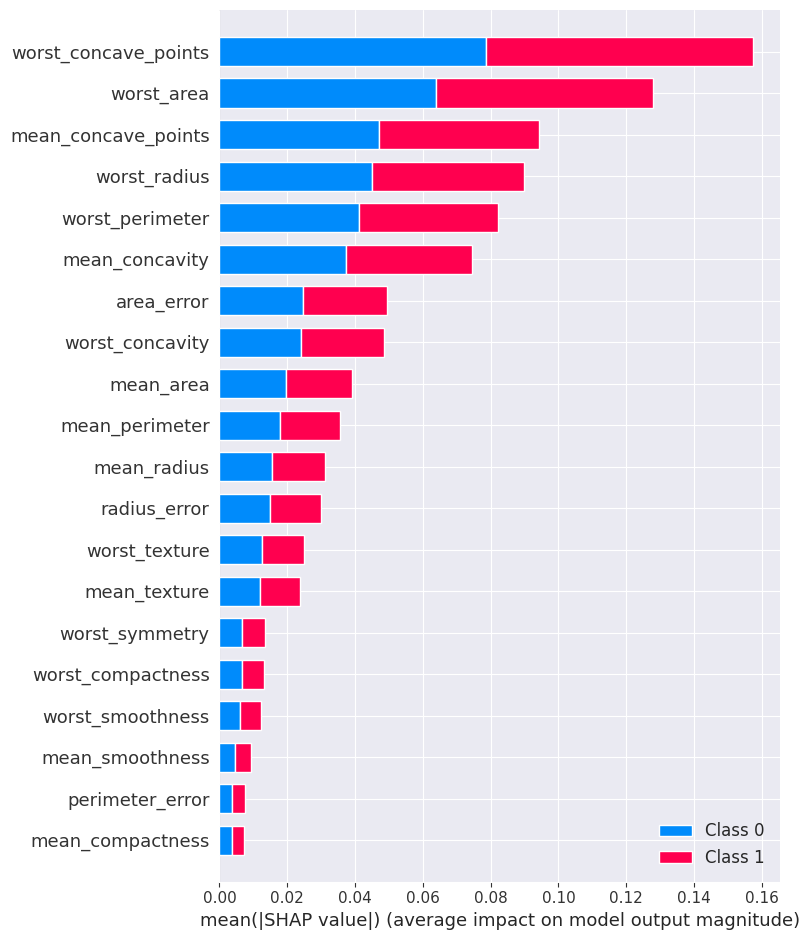

In [214]:
shap.summary_plot(shap_values,train[features])#, features=None, feature_names=features, max_display=None)

In [215]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1],discount_importance=False)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF worst_area <839.6499938964844 AND worst_concave_points <0.14305000007152557 THEN class = 1 # 0.9827586206896551\n']

In [216]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9370629370629371


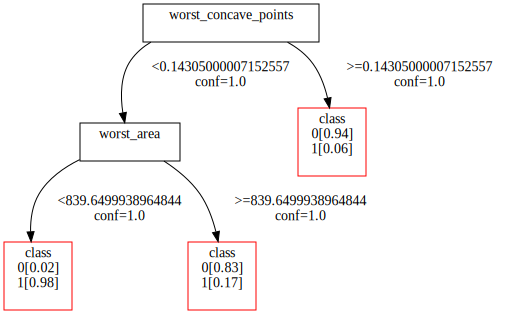

In [217]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance with SHAP support')

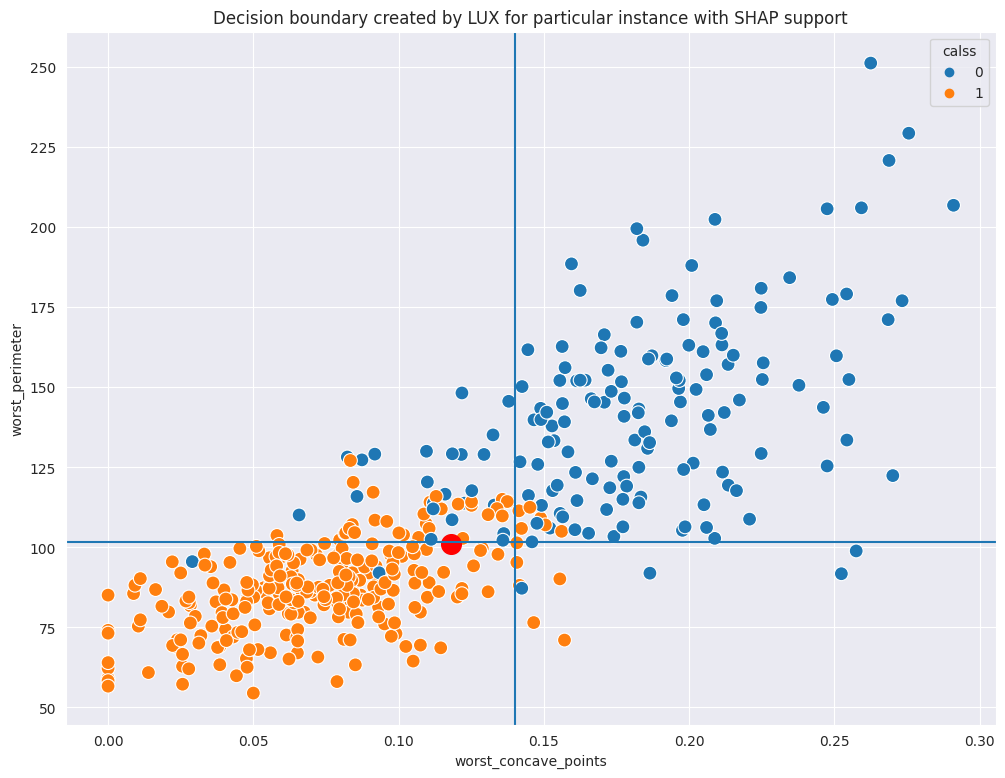

In [218]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_concave_points',y='worst_perimeter', data=train[['worst_concave_points','worst_perimeter',target]],hue=target,s=100)
graph.axvline(0.14)
graph.axhline(101.8)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='worst_concave_points',y='worst_perimeter', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')